# Inventory Monitoring at Distribution Centers
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.


Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, I will build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items.


This notebook is used to fine-tune a pre-trained CNN model to classify the number of objects in a bin.  The main steps are:

Step 1: Data Preparation

Step 2: Model Training

Step 3: Hyperparameter Tuning

Step 4: Deploying to Endpoint


### Citation

Amazon Bin Image Dataset was accessed on 18 Dec from https://registry.opendata.aws/amazon-bin-imagery.

In [ ]:
# TODO: Install any packages that you might need

In [1]:
# TODO: Import any packages that you might need
import os
import json
import boto3
import numpy as np
import random
from tqdm import tqdm
import IPython
import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    ProfilerConfig, 
    FrameworkProfile,
    rule_configs,
    CollectionConfig
)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

[2021-12-23 12:38:14.566 ip-172-16-159-85:28298 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation

As part of the starter files, "file_list.json" contains a dictionary with class labels as keys and image path as values. Each of these keys contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. I notice that "file_list.json" only contains images with up to 5 items.

In the following cells, I will create files in similar format for validation and testing data.

### Creating json file for validation and testing dataset

In the [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/) documentation, there is a [link](https://github.com/silverbottlep/abid_challenge) on usage examples.  The metadata of all the images have been added into a [file](http://www.cs.unc.edu/~eunbyung/abidc/metadata.json).  I will use this file to generate my validation and testing dataset

In [ ]:
# download the metadata file
!curl -O "http://www.cs.unc.edu/~eunbyung/abidc/metadata.json"

In [ ]:
# read the metadata file and print the number of images

metadata_file = "metadata.json"

print("loading metadata!")
with open(metadata_file) as json_file:
    metadata = json.load(json_file)
N = len(metadata)
print (N)

In [ ]:
# pick 1500 sample images for validation and testing

val_sample = random.sample(range(N),1500)
test_sample = random.sample(range(N),1500)

In [ ]:
# declare validation and test dictionaries
val_list = {}
test_list = {}

# initialize dictionaries
for idx in range(6):
    idx_str = str(idx)
    val_list[idx_str] = []
    test_list[idx_str] = []

In [ ]:
# iterate through the metadata to get the validation and test dataset
for idx in val_sample:
    quantity = metadata[idx]['EXPECTED_QUANTITY']
    if quantity < 6:
        qty_str = str(quantity)
        filenum = idx + 1
        filestr = str(filenum).zfill(5)
        filename = 'data/metadata/' + str(filestr) + ".json"
        val_list[qty_str].append(filename)

for idx in test_sample:
    quantity = metadata[idx]['EXPECTED_QUANTITY']
    if quantity < 6:
        qty_str = str(quantity)
        filenum = idx + 1
        filestr = str(filenum).zfill(5)
        filename = 'data/metadata/' + str(filestr) + ".json"
        test_list[qty_str].append(filename)
        
# delete items with 0 quantity
val_list.pop('0')    
test_list.pop('0')

In [ ]:
# write validation and test json files
val_fname = "file_list_val.json"
test_fname = "file_list_test.json"

with open(val_fname, 'w') as convert_file:
     convert_file.write(json.dumps(val_list))

with open(test_fname, 'w') as convert_file:
     convert_file.write(json.dumps(test_list))

### Download training, validation and testing images into workspace

In [27]:
def download_and_arrange_data(file, folder):
    s3_client = boto3.client('s3')

    with open(file, 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(folder, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

# download_and_arrange_data()

In [2]:
# download training data into workspace
download_and_arrange_data('file_list.json','train_data')

100%|██████████| 1228/1228 [01:30<00:00, 13.63it/s]


100%|██████████| 2299/2299 [02:52<00:00, 13.30it/s]


100%|██████████| 2666/2666 [03:43<00:00, 11.92it/s]


100%|██████████| 2373/2373 [03:20<00:00, 11.85it/s]


100%|██████████| 1875/1875 [02:39<00:00, 11.78it/s]


In [28]:
# download validation data into workspace
download_and_arrange_data('file_list_val.json','valid_data')

100%|██████████| 144/144 [00:12<00:00, 11.66it/s]


100%|██████████| 214/214 [00:18<00:00, 11.37it/s]


100%|██████████| 267/267 [00:23<00:00, 11.20it/s]


100%|██████████| 223/223 [00:19<00:00, 11.42it/s]


100%|██████████| 167/167 [00:14<00:00, 11.47it/s]


In [29]:
# download testing data into workspace
download_and_arrange_data('file_list_test.json','test_data')

100%|██████████| 120/120 [00:09<00:00, 12.14it/s]


100%|██████████| 208/208 [00:17<00:00, 11.60it/s]


100%|██████████| 242/242 [00:21<00:00, 11.42it/s]


100%|██████████| 243/243 [00:21<00:00, 11.47it/s]


100%|██████████| 190/190 [00:16<00:00, 11.58it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

The [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/) contains more than 500,000 images of bins containing one or more objects. For this project, I have selected a sample dataset for training, validation and testing purposes.  In the following cells, I will display the dataset sizes and a histogram of the data distribution

### Dataset Statistics



In [3]:
# count size of training, validation and testing datasets

def count_data_size(file, dict):
    s3_client = boto3.client('s3')
    count = 0
    with open(file, 'r') as f:
        d=json.load(f)
    for k, v in d.items():
        if k not in dict:
            dict[k] = 0
        for file_path in v:
            dict[k] = dict[k] + 1

    return dict

In [16]:
train_dict = {}
test_dict = {}
val_dict = {}

train_dict = count_data_size('file_list.json',train_dict)
val_dict = count_data_size('file_list_val.json',val_dict)
test_dict = count_data_size('file_list_test.json',test_dict)

print("Number of images in training dataset: {} ".format(sum(train_dict.values())))
print("Number of images in validation dataset: {} ".format(sum(val_dict.values())))
print("Number of images in testing dataset: {} ".format(sum(test_dict.values())))


Number of images in training dataset: 10441 
Number of images in validation dataset: 1015 
Number of images in testing dataset: 1003 


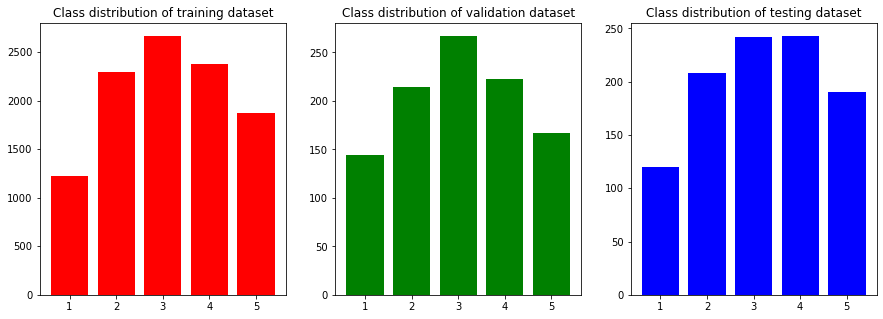

In [25]:
# show the data distribution of training, validation and testing dataset

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].bar(list(train_dict.keys()), train_dict.values(), color='r')
ax[1].bar(list(val_dict.keys()), val_dict.values(), color='g')
ax[2].bar(list(test_dict.keys()), test_dict.values(), color='b')

ax[0].title.set_text('Class distribution of training dataset')
ax[1].title.set_text('Class distribution of validation dataset')
ax[2].title.set_text('Class distribution of testing dataset')

plt.show()

### Uploading data to S3

Finally, I will upload the training, validation and testing datasets into my S3 buckets

In [40]:
%%capture
!aws s3 cp train_data s3://inventory-jy/train/ --recursive

In [30]:
%%capture
!aws s3 cp test_data s3://inventory-jy/test/ --recursive

In [31]:
%%capture
!aws s3 cp valid_data s3://inventory-jy/valid/ --recursive

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [33]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

hyperparameters = {
    "lr": "0.05",
    "batch-size": "32"
}



In [34]:
#TODO: Create your training estimator

estimator = PyTorch(
    entry_point="train.py",
    base_job_name="inventory-monitoring",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge", # 17 mins for 10 epochs
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)

In [35]:
# TODO: Fit your estimator
# Retrieve S3 data input paths
inputs = 's3://inventory-jy'

estimator.fit( 
    {
        "train": inputs+'/train',
        "test": inputs+'/test',
        "val": inputs+'/valid'
    }, wait = True
)

2021-12-22 14:01:13 Starting - Starting the training job...
2021-12-22 14:01:18 Starting - Launching requested ML instancesProfilerReport-1640181672: InProgress
......
2021-12-22 14:02:36 Starting - Preparing the instances for training......
2021-12-22 14:03:42 Downloading - Downloading input data..................
2021-12-22 14:06:37 Training - Downloading the training image.........
2021-12-22 14:08:02 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-22 14:08:02,794 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-22 14:08:02,817 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-22 14:08:03,434 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-22 14:08:03,930 sagemaker-training-toolkit INFO     Invoking user script
Tra

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [2]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),    
}


In [3]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    base_job_name="inventory-monitoring",
    role=get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

# Objective is to minimize average test loss
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

#tuner = # TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)


In [4]:
# TODO: Fit your estimator
inputs = 's3://inventory-jy'

tuner.fit( 
    {
        "train": inputs+'/train',
        "test": inputs+'/test',
        "val": inputs+'/valid'
    }, wait = True
)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [7]:
# TODO: Find the best hyperparameters
best_estimator=tuner.best_estimator()
print("Best training job: {}".format(tuner.best_training_job()))
best_estimator.hyperparameters()


2021-12-23 13:01:07 Starting - Preparing the instances for training
2021-12-23 13:01:07 Downloading - Downloading input data
2021-12-23 13:01:07 Training - Training image download completed. Training in progress.
2021-12-23 13:01:07 Uploading - Uploading generated training model
2021-12-23 13:01:07 Completed - Training job completed
Best training job: pytorch-training-211223-1238-001-99f33723


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.040564834458224286',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"inventory-monitoring-2021-12-23-12-38-30-591"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-12-38-30-591/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [8]:
# if kernel was interrupted, retrieve the latest training job

#BetterTrainingJobName='pytorch-training-211223-1238-001-99f33723'
#best_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.040564834458224286',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"inventory-monitoring-2021-12-23-12-38-30-591"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-12-38-30-591/source/sourcedir.tar.gz"'}

In [9]:
# TODO: Set up debugging and profiling rules and hooks
# Specify debugger and profiler rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()), # check for vanishing gradient
    Rule.sagemaker(rule_configs.overfit()), # check for overfitting
    Rule.sagemaker(rule_configs.overtraining()), # check for overtraining
    Rule.sagemaker(rule_configs.poor_weight_initialization()), # check for poor weight initialization
    Rule.sagemaker(rule_configs.loss_not_decreasing()), # check for loss not decreasing
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()), # check for low GPU utilization
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),   # generate profiler report
]

# Debugger collects loss values every 10 steps from training loops and every 5 steps from evaluation loops.
collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0", 
            "train.save_interval": "10",
            "eval.save_interval": "5"
        }
    )
]

hook_config=DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "5"},
    collection_configs=collection_configs
)

# Profiler - track metrics every 500 ms
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)

In [10]:
# Retrieve the best hyperparameters

hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr']}
hyperparameters

{'batch-size': 32, 'lr': '0.040564834458224286'}

In [11]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="debug.py",
    base_job_name="inventory-monitoring",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge", #GPU
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    # Profiler parameters
    profiler_config=profiler_config,
)

In [12]:
inputs = 's3://inventory-jy'

estimator.fit( 
    {
        "train": inputs+'/train',
        "test": inputs+'/test',
        "val": inputs+'/valid'
    }, wait = True
)

2021-12-23 13:53:09 Starting - Starting the training job...
2021-12-23 13:53:39 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-23 13:54:40 Starting - Preparing the instances for training.........
2021-12-23 13:56:01 Downloading - Downloading input data............
2021-12-23 13:58:02 Training - Downloading the training image.........
2021-12-23 13:59:33 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-23 13:59:31,191 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-23 13:59:31,209 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-23 13:59:31,221 sag

In [13]:
# TODO: Plot a debugging output.

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

#Print Tensor names
trial.tensor_names()

[2021-12-23 14:20:09.797 ip-172-16-159-85:28298 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/debug-output
[2021-12-23 14:20:10.385 ip-172-16-159-85:28298 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 1829 more expected)', IncompleteRead(0 bytes read, 1829 more expected)) while reading s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/debug-output/index/000000000/000000000270_worker_0.json . Will retry now
[2021-12-23 14:20:16.559 ip-172-16-159-85:28298 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-23 14:20:17.583 ip-172-16-159-85:28298 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [14]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

359

In [15]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

64

In [16]:
# create functions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.title("Cross Entropy Loss for Training and Validation")
    
    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


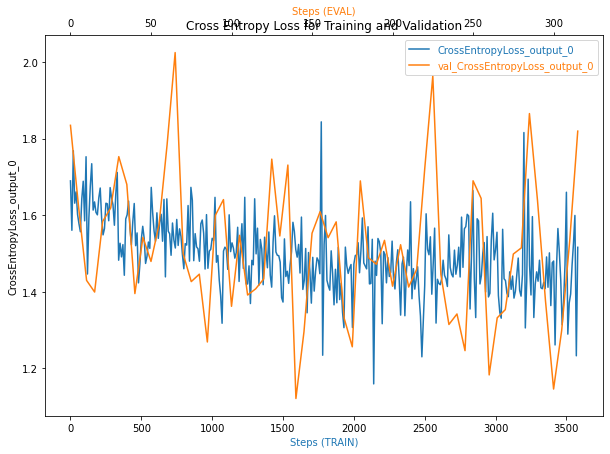

In [17]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

I notice that the training loss decreases gradually and there is not much improvement after 2000 steps.  There is no clear downward trend in validation loss. 

This could be due to overfitting when training on a small dataset (10441 images for training).  To improve the model training, I will increase the number of images used for training to reduce overfitting.

In [18]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [19]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sag

In [20]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

I will be creating a PyTorch Model using my own inference.py script.  Thereafter, I will deploy the model to an endpoint

In [21]:
# TODO: Deploy your model to an endpoint

# find the location of the saved model
model_dir=estimator.model_data
model_dir

's3://sagemaker-us-east-1-215702958634/inventory-monitoring-2021-12-23-13-53-08-796/output/model.tar.gz'

In [23]:
# Create a PyTorch Model that can be deployed to SageMaker endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
pytorch_model = PyTorchModel(model_data=model_dir, 
                             role=get_execution_role(), 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

In [24]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.t2.medium") 

-----------!

In [25]:
# TODO: Run an prediction on the endpoint

test_file = "./test_data/1/04309.jpg"

with open(test_file, "rb") as f:
    payload = f.read()
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

# find the position of largest value which corresponds to predicted class
np.argmax(response, 1)

array([0])

This correspond to the label '1' which is a correct prediction!

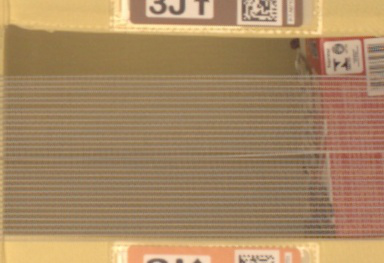

In [26]:
# Preview the test image

from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [27]:
# check to ensure that 5 predictions are returned
print(len(response[0]))

5


In [28]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances
BetterTrainingJobName='pytorch-training-211222-1009-004-9f36c7de'
best_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
    
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr']}

estimator = PyTorch(
    entry_point="train.py",
    base_job_name="inventory-monitoring",
    role=get_execution_role(),
    instance_count=2, # multiple instances
    instance_type="ml.g4dn.xlarge", # 17 mins for 10 epochs
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)